# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [10]:
df = pd.read_csv("bikes_rent.csv")

Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

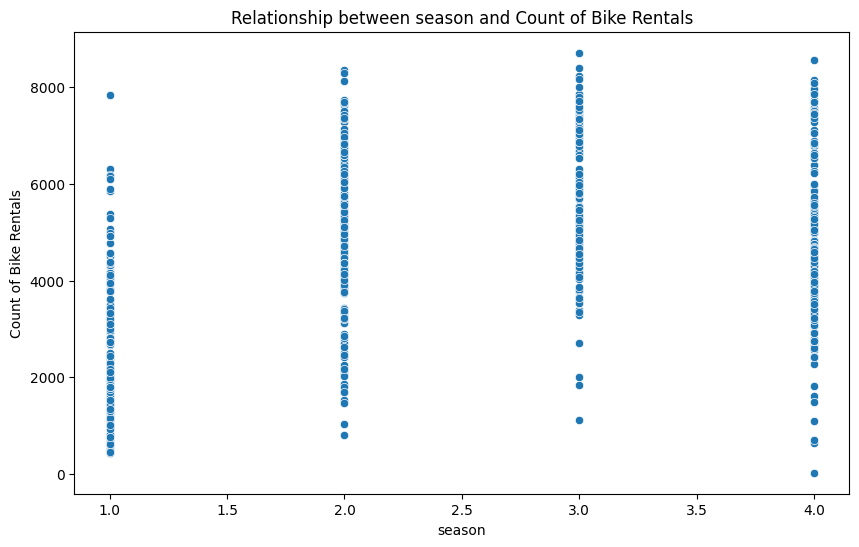

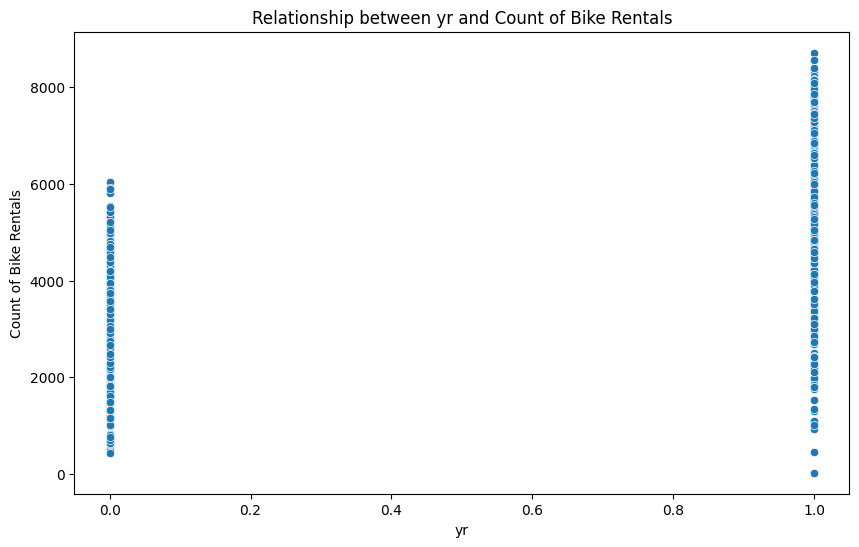

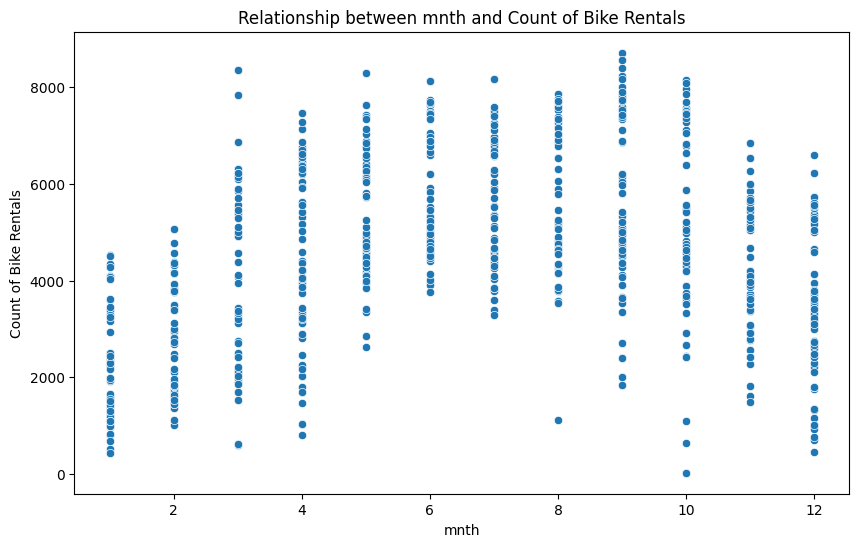

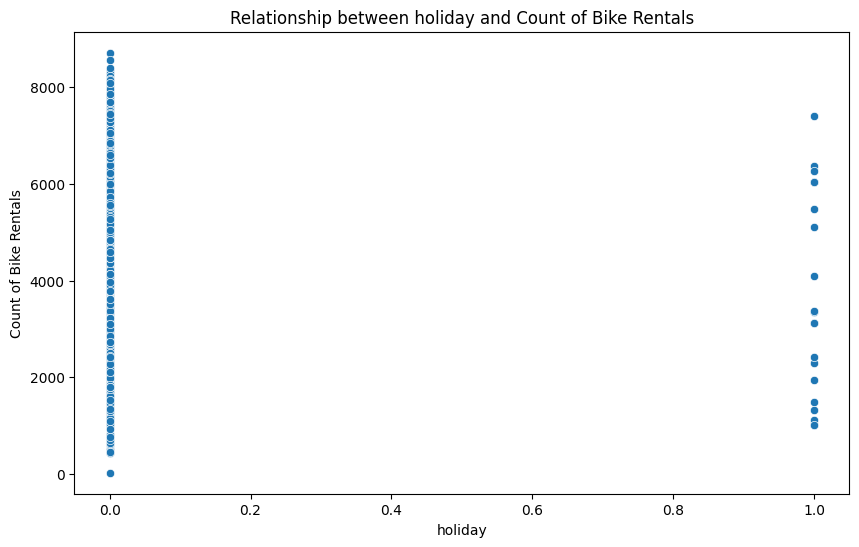

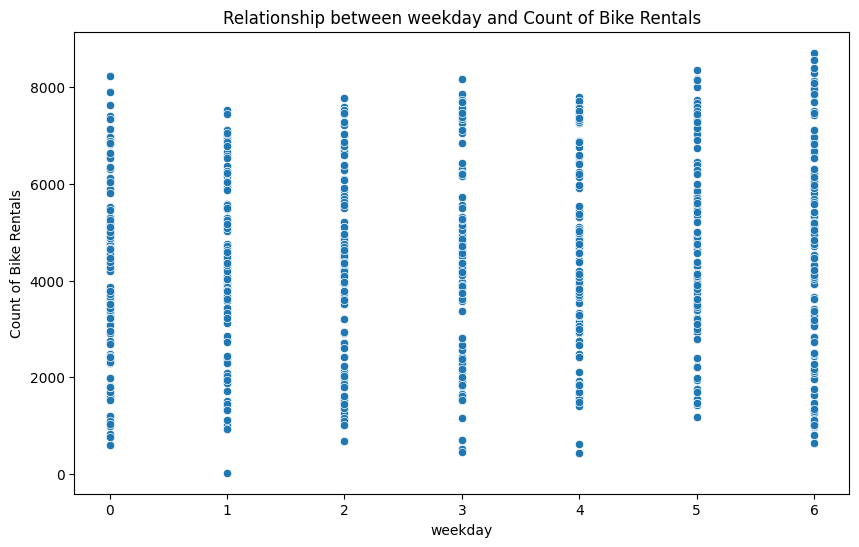

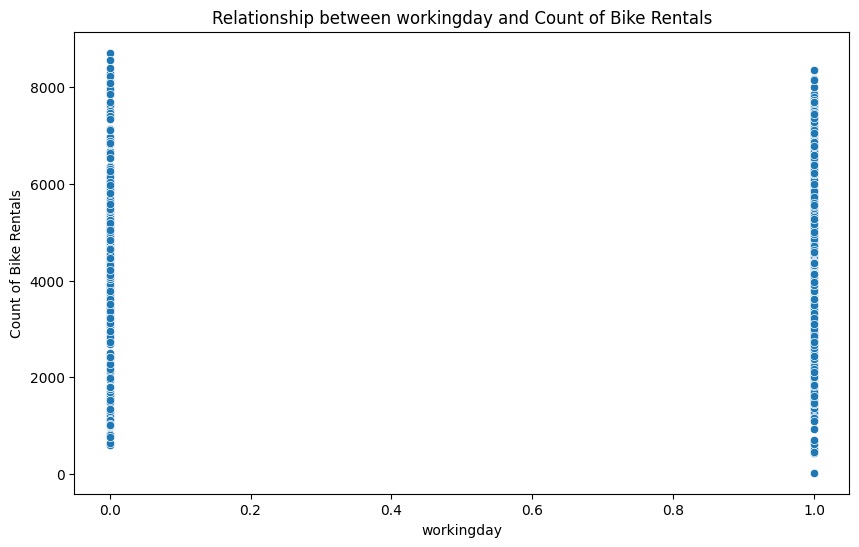

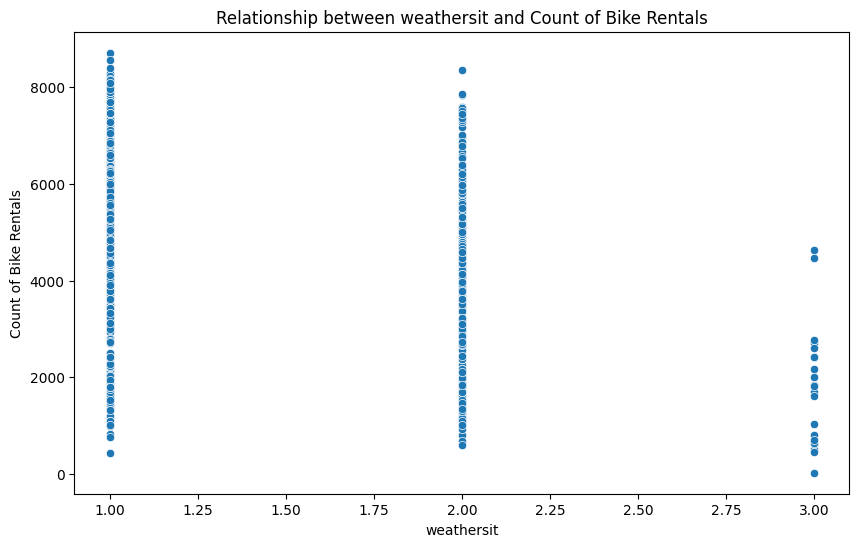

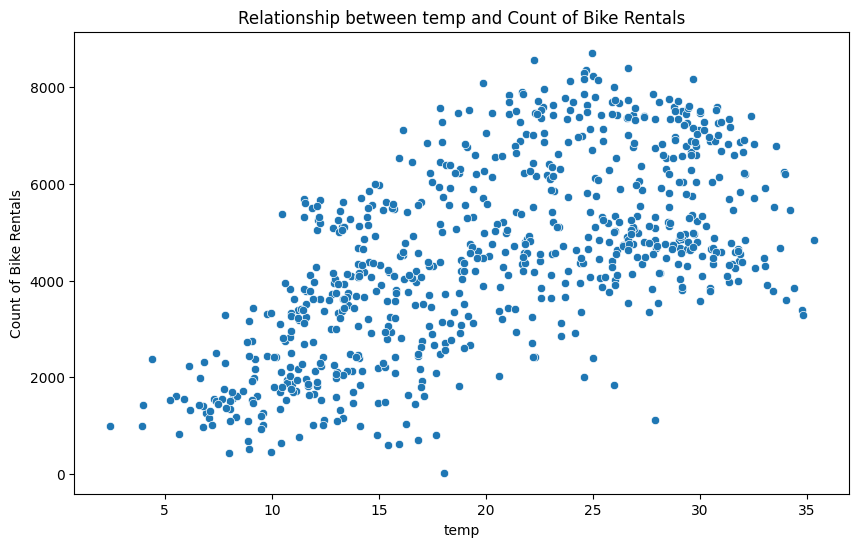

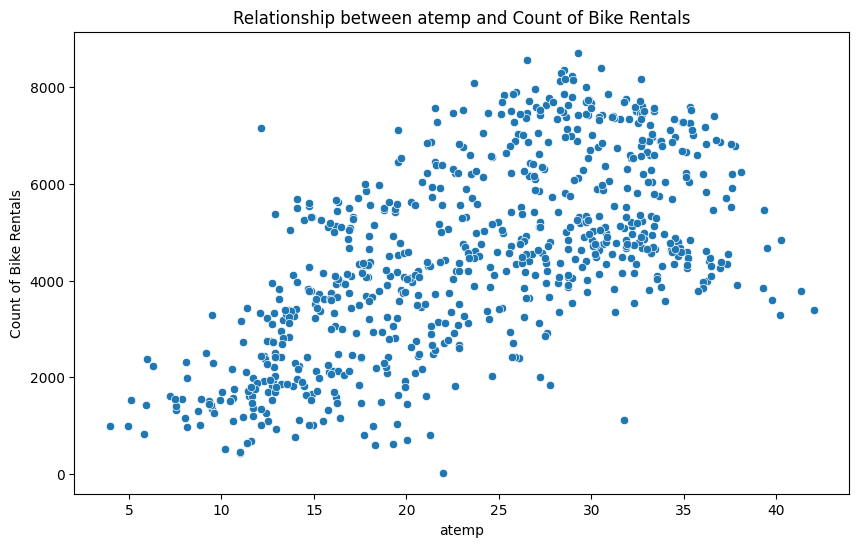

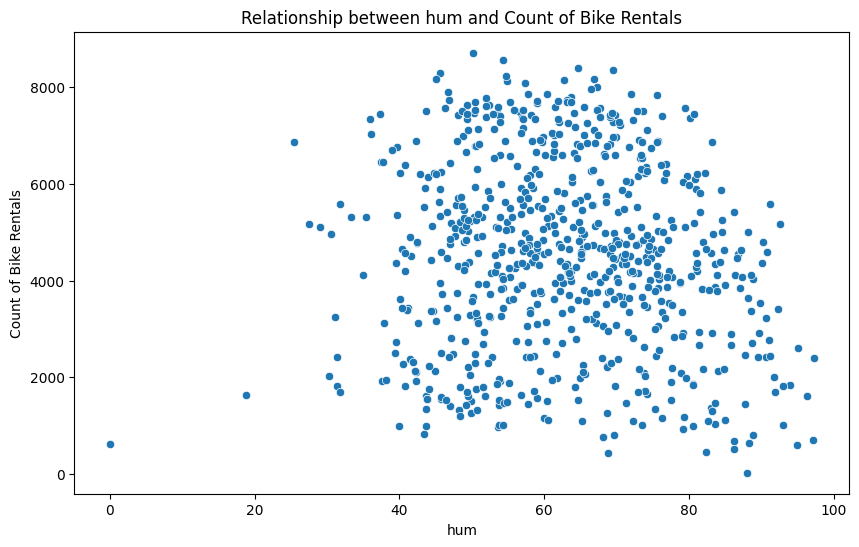

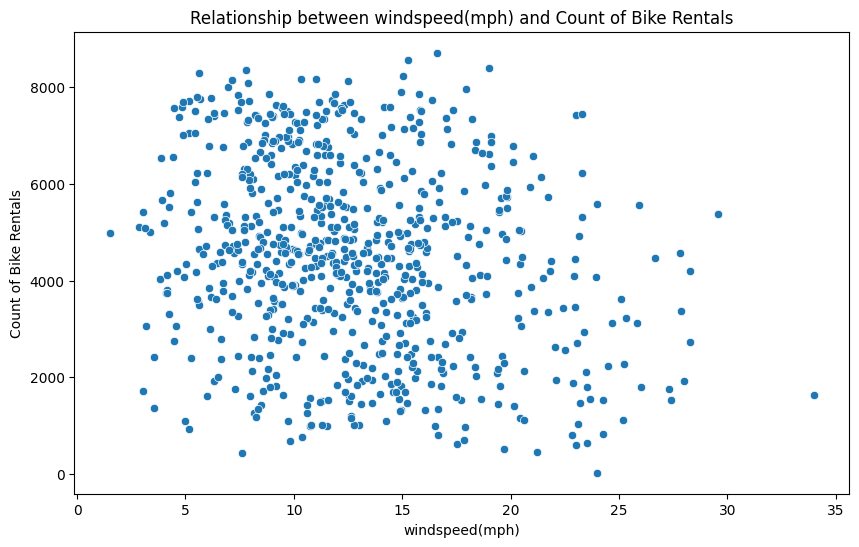

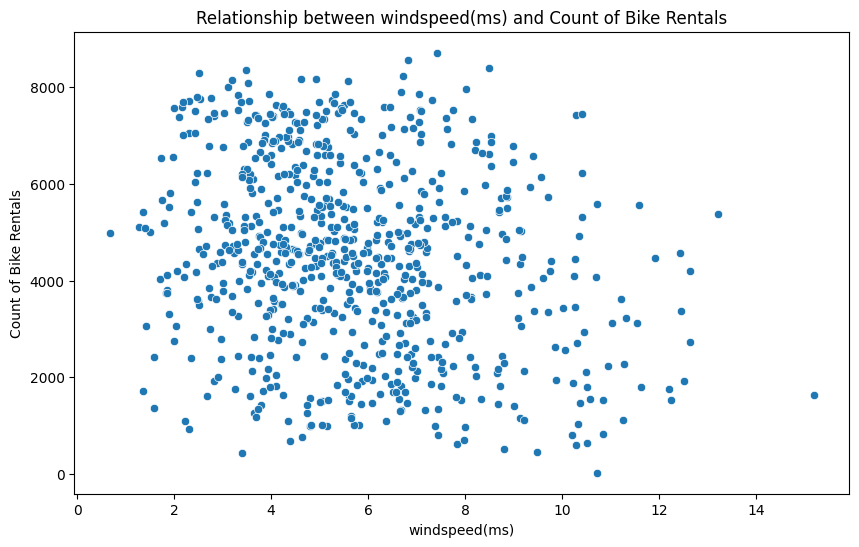

In [12]:
# Put you code here
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

for attribute in attributes:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[attribute], y=df['cnt'])
    plt.title(f'Relationship between {attribute} and Count of Bike Rentals')
    plt.xlabel(attribute)
    plt.ylabel('Count of Bike Rentals')
    plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [13]:
# Put your code here
features = df.columns[:-1]
correlations = df[features].corrwith(df['cnt'])
print("Correlations with 'cnt':")
print(correlations)

Correlations with 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [14]:
# Put your code here
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlation_matrix = df[selected_features].corr()
print("Pairwise Correlations:")
print(correlation_matrix)

Pairwise Correlations:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [15]:
# Put your code here
mean_values = df.mean()
print("Mean Values:")
print(mean_values)

normalized_data = (df - df.mean()) / df.std()

print("\nNormalized Data:")
print(normalized_data.head())

Mean Values:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Normalized Data:
     season        yr      mnth   holiday   weekday  workingday  weathersit  \
0 -1.347291 -1.000684 -1.599066 -0.171863  1.497783   -1.470218    1.109667   
1 -1.347291 -1.000684 -1.599066 -0.171863 -1.495054   -1.470218    1.109667   
2 -1.347291 -1.000684 -1.599066 -0.171863 -0.996248    0.679241   -0.725551   
3 -1.347291 -1.000684 -1.599066 -0.171863 -0.497441    0.679241   -0.725551   
4 -1.347291 -1.000684 -1.599066 -0.171863  0.001365    0.679241   -0.725551   

       temp     atemp       hum  windspeed(mph)  windspeed(ms)       cnt  
0 -0.826097 -0

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [21]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [22]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [ ]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [27]:
# Put your code here
from sklearn.linear_model import LinearRegression

X = df[df.columns[:-1]]
y = df["cnt"]

linear_regressor = LinearRegression()

linear_regressor.fit(X, y)

feature_weights = list(zip(X.columns, linear_regressor.coef_))

print("Feature weights:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

Feature weights:
season: 514.2728995610262
yr: 2043.9382634858337
mnth: -40.961945246475764
holiday: -519.3813114695563
weekday: 68.49475530920074
workingday: 121.29451190972294
weathersit: -606.4618338795516
temp: 48.9964748785253
atemp: 71.91388967815254
hum: -10.230243272939399
windspeed(mph): 2400935539305.8076
windspeed(ms): -5370892801511.889


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [29]:
# Put your code here
from sklearn.linear_model import Lasso, Ridge


lasso_regressor = Lasso()
ridge_regressor = Ridge()


lasso_regressor.fit(X, y)
ridge_regressor.fit(X, y)


lasso_weights = list(zip(X.columns, lasso_regressor.coef_))
print("Lasso Feature weights:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")


ridge_weights = list(zip(X.columns, ridge_regressor.coef_))
print("\nRidge Feature weights:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")

Lasso Feature weights:
season: 506.5512786498074
yr: 2036.231667697904
mnth: -38.0782702893216
holiday: -484.6519461865404
weekday: 68.93837479133961
workingday: 118.44759758668346
weathersit: -604.5667118927047
temp: 51.36326058561614
atemp: 69.91273749012211
hum: -10.352705204636575
windspeed(mph): -38.341067613108486
windspeed(ms): -0.0

Ridge Feature weights:
season: 507.80188185056346
yr: 2029.0890541970514
mnth: -38.4708972791211
holiday: -493.2780154838204
weekday: 69.11396965165969
workingday: 121.52442502929453
weathersit: -605.2055553731528
temp: 49.31676759598268
atemp: 71.78598727335023
hum: -10.38339450048464
windspeed(mph): -31.9355016942676
windspeed(ms): -14.27604026388054


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [30]:
# Put your code here
ridge_regressor = Ridge()

ridge_regressor.fit(X, y)

ridge_weights = list(zip(X.columns, ridge_regressor.coef_))
print("Ridge Feature weights:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")

Ridge Feature weights:
season: 507.80188185056346
yr: 2029.0890541970514
mnth: -38.4708972791211
holiday: -493.2780154838204
weekday: 69.11396965165969
workingday: 121.52442502929453
weathersit: -605.2055553731528
temp: 49.31676759598268
atemp: 71.78598727335023
hum: -10.38339450048464
windspeed(mph): -31.9355016942676
windspeed(ms): -14.27604026388054


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [32]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    ridge_regressor = Ridge(alpha=alpha)
    
    lasso_regressor.fit(X, y)
    ridge_regressor.fit(X, y)
    
    coefs_lasso.append(lasso_regressor.coef_)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

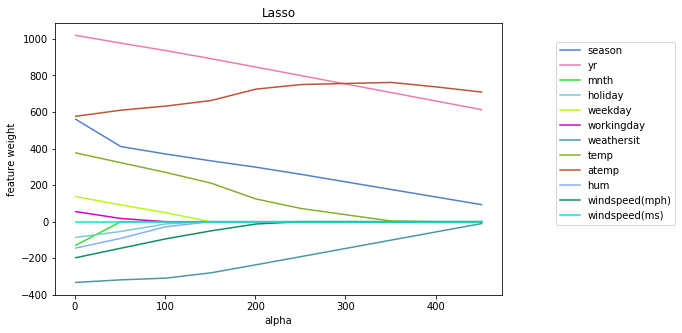

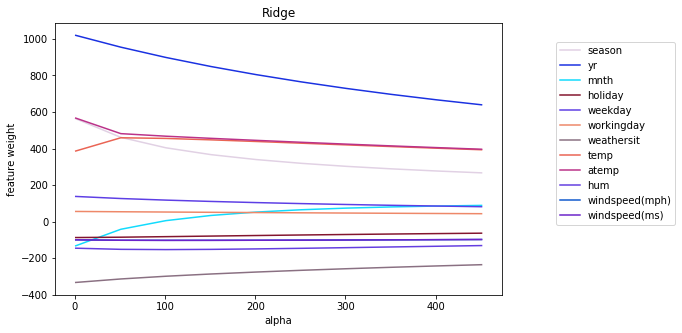

In [ ]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [39]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

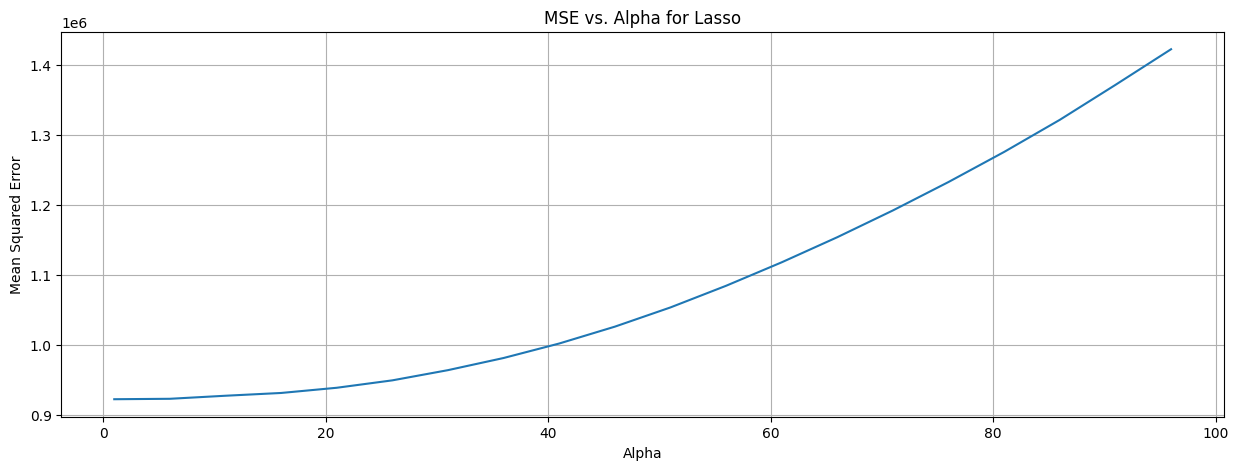

Selected alpha: 1

Feature weights:
season: 506.5512786498074
yr: 2036.231667697904
mnth: -38.0782702893216
holiday: -484.6519461865404
weekday: 68.93837479133961
workingday: 118.44759758668346
weathersit: -604.5667118927047
temp: 51.36326058561614
atemp: 69.91273749012211
hum: -10.352705204636575
windspeed(mph): -38.341067613108486
windspeed(ms): -0.0


In [40]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)

regressor.fit(X, y)

alpha_mse_pairs = list(zip(regressor.alphas_, np.mean(regressor.mse_path_, axis=1)))
create_plot(alpha_mse_pairs, "MSE vs. Alpha for Lasso", "Alpha", "Mean Squared Error")
print(f"Selected alpha: {regressor.alpha_}")

lasso_coefs = list(zip(X.columns, regressor.coef_))
print("\nFeature weights:")
for feature, weight in lasso_coefs:
    print(f"{feature}: {weight}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alpha values corresponding to minimum MSE on each fold:
[ 1 51  1]


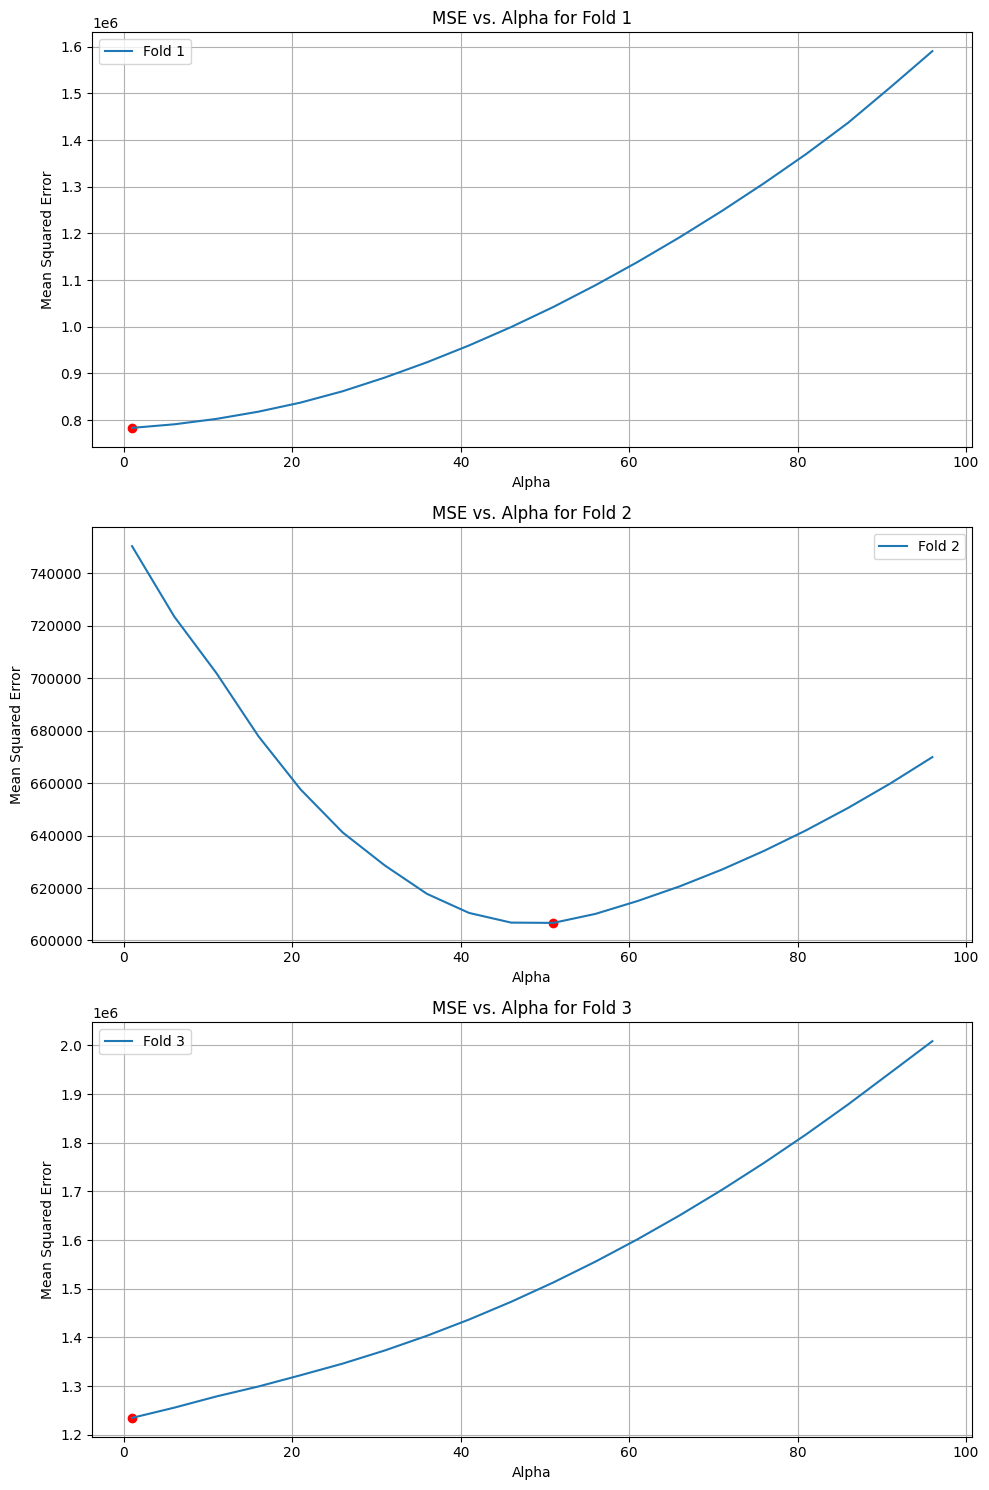

In [45]:
# Put your code here
min_alpha_indices = np.argmin(regressor.mse_path_, axis=0)
min_alpha_values = regressor.alphas_[min_alpha_indices]
print("Alpha values corresponding to minimum MSE on each fold:")
print(min_alpha_values)

# Визуализация столбцов mse_path_
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for i in range(3):
    axs[i].plot(regressor.alphas_, regressor.mse_path_[:, i], label=f"Fold {i + 1}")
    axs[i].scatter(min_alpha_values[i], np.min(regressor.mse_path_[:, i]), color='red')
    axs[i].set_title(f"MSE vs. Alpha for Fold {i + 1}")
    axs[i].set_xlabel("Alpha")
    axs[i].set_ylabel("Mean Squared Error")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [11]:
# ???
Логично предположить, что чем больше значение этих признаков, тем больше людей захотят взять велосипеды, если выбранные признаки имеют реальное влияние на спрос.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [46]:
Выбрал 3 признака:[weathersit, windspeed(mph), windspeed(ms)]
Исходя из здравого смысла, можно предположить, что увеличение значения признаков, таких как weathersit, windspeed(mph), windspeed(ms), может быть связано с ухудшением погодных условий или увеличением скорости ветра, что потенциально может уменьшить количество велосипедов, взятых в прокат (и, следовательно, убывающая линейная зависимость).

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [13]:
Анализируя графики, можно предположить, что модель исключила эти признаки, поскольку они могли демонстрировать слабую или отсутствующую линейную зависимость с целевой переменной cnt. Вероятно, эти признаки не содержат значимой информации для прогнозирования спроса на велосипеды в данном контексте, и, следовательно, модель решает их исключить для повышения обобщающей способности.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.